## Collect Data

In [26]:
import os
import re
import sqlite3
import json
from urllib.parse import urlparse
from collections import Counter

def extractRequests(entry, host):
    request = entry.get('request', {})
    if 'url' in request:
        request_url_parts = urlparse(request['url']).hostname.rsplit('.')
        if (request_url_parts[-1] == 'uk' and request_url_parts[-2] == 'co'):
            request_url = request_url_parts[-3] + '.' + request_url_parts[-2] + '.' + request_url_parts[-1]
        elif len(request_url_parts) >= 2: 
            request_url = request_url_parts[-2] + '.' + request_url_parts[-1]
        else:
            return None    

        if host not in request_url:
            return request_url

    return None

def processFolder(path):
    allDomains = []
    for filename in os.listdir(path):
        if filename.endswith('.har'):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                harData = json.load(file)
                entries = harData.get('log', {}).get('entries', [])
                for entry in entries:
                    match = re.search(r'(m|www)\.(.*)(\.har)', filename)
                    host = match.group(2) if match else None
                    
                    domain = extractRequests(entry, host)
                    if domain:
                        allDomains.append((domain, host, re.search(r'/(desktop|mobile)/', path).group(1)))
    return allDomains

dbConnect = sqlite3.connect('third_party_analysis.db')
dbCursor = dbConnect.cursor()

dbCursor.execute('''
    CREATE TABLE IF NOT EXISTS domain_counts (
        id INTEGER PRIMARY KEY,
        domain TEXT,
        host TEXT,
        type TEXT
    )
''')

paths = ['../archives/news/desktop/', '../archives/news/mobile/', '../archives/shops/desktop/', '../archives/shops/mobile/']

allDomains = []

for path in paths:
    allDomains += processFolder(path)

for domain, host, type in allDomains:
    dbCursor.execute('INSERT INTO domain_counts (domain, host, type) VALUES (?, ?, ?)', (domain, host, type))

dbConnect.commit()
dbConnect.close()

### Requests to third parties

In [27]:
conn = sqlite3.connect('third_party_analysis.db')
cursor = conn.cursor()

query = 'SELECT domain, COUNT(*) FROM domain_counts GROUP BY domain ORDER BY COUNT(*) DESC'

cursor.execute(query)

data1 = cursor.fetchall()

print("Domain\tCount")
print("----------------------------")
for domain, count in data1:
    print(f"{count}\t{domain}")

conn.close()

Domain	Count
----------------------------
1922	media-amazon.com
1655	doubleclick.net
1332	googlesyndication.com
969	adsafeprotected.com
955	google.com
666	ztat.net
666	adobedtm.com
602	asadcdn.com
597	ssl-images-amazon.com
547	google-analytics.com
546	guim.co.uk
442	adnxs.com
424	rubiconproject.com
394	amazon-adsystem.com
353	gstatic.com
317	googletagmanager.com
313	criteo.com
311	outbrain.com
285	taboola.com
284	adform.net
244	2mdn.net
242	google.de
238	googletagservices.com
229	idcdn.de
228	creativecdn.com
223	teads.tv
216	facebook.com
208	cookielaw.org
197	aboutyou.cloud
193	smartadserver.com
191	cloudfront.net
187	pinterest.com
184	googleapis.com
178	tiktok.com
173	pubmatic.com
173	casalemedia.com
164	ctfassets.net
163	cxense.com
158	bounceexchange.com
153	snapchat.com
145	yieldlab.net
145	chartbeat.net
143	ioam.de
137	googleadservices.com
137	abtasty.com
136	glomex.com
135	xplosion.de
134	cnn.io
133	salesforce.com
132	otto.de
126	presage.io
121	bing.com
119	dwcdn.net
115	optimizel

### Compare Requests by device type

In [28]:
conn = sqlite3.connect('third_party_analysis.db')
cursor = conn.cursor()

query = 'SELECT type, COUNT(*) FROM domain_counts GROUP BY type ORDER BY COUNT(*) DESC'

cursor.execute(query)

data2 = cursor.fetchall()

print("Count\tdevice type")
print("----------------------------")
for domain, count in data2:
    print(f"{count}\t{domain}")

conn.close()

Count	device type
----------------------------
18733	desktop
9590	mobile


### Compare amount of request of each website

In [29]:
conn = sqlite3.connect('third_party_analysis.db')
cursor = conn.cursor()

query = 'SELECT host, type, COUNT(*) FROM domain_counts GROUP BY host, type'

cursor.execute(query)
data3 = cursor.fetchall()

print("Count\tDevice Type\t\Host")
print("------------------------------------")
for host, type, count in data3:
    print(f"{count}\t{type}\t\t{host}")

conn.close()

Count	Device Type	\Host
------------------------------------
2576	desktop		amazon.de
99	mobile		amazon.de
1477	desktop		bild.de
577	mobile		bild.de
628	desktop		cnn.com
982	mobile		cnn.com
839	desktop		depot-online.de
370	mobile		depot-online.de
41	desktop		douglas.de
225	mobile		douglas.de
1335	desktop		faz.net
533	mobile		faz.net
306	desktop		hm.com
159	mobile		hm.com
1672	desktop		merkur.de
1084	mobile		merkur.de
722	desktop		n-tv.de
924	mobile		n-tv.de
502	desktop		nike.com
84	mobile		nike.com
982	desktop		samsung.com
104	mobile		samsung.com
139	desktop		saturn.de
317	mobile		saturn.de
1594	desktop		sephora.de
122	mobile		sephora.de
832	desktop		sueddeutsche.de
553	mobile		sueddeutsche.de
896	desktop		telegraph.co.uk
1373	mobile		telegraph.co.uk
1688	desktop		theguardian.com
579	mobile		theguardian.com
954	desktop		thehindu.com
819	mobile		thehindu.com
391	desktop		uniqlo.com
160	mobile		uniqlo.com
727	desktop		zalando.de
128	mobile		zalando.de
432	desktop		zeit.de
398	mobile		zeit

## Data Visualization

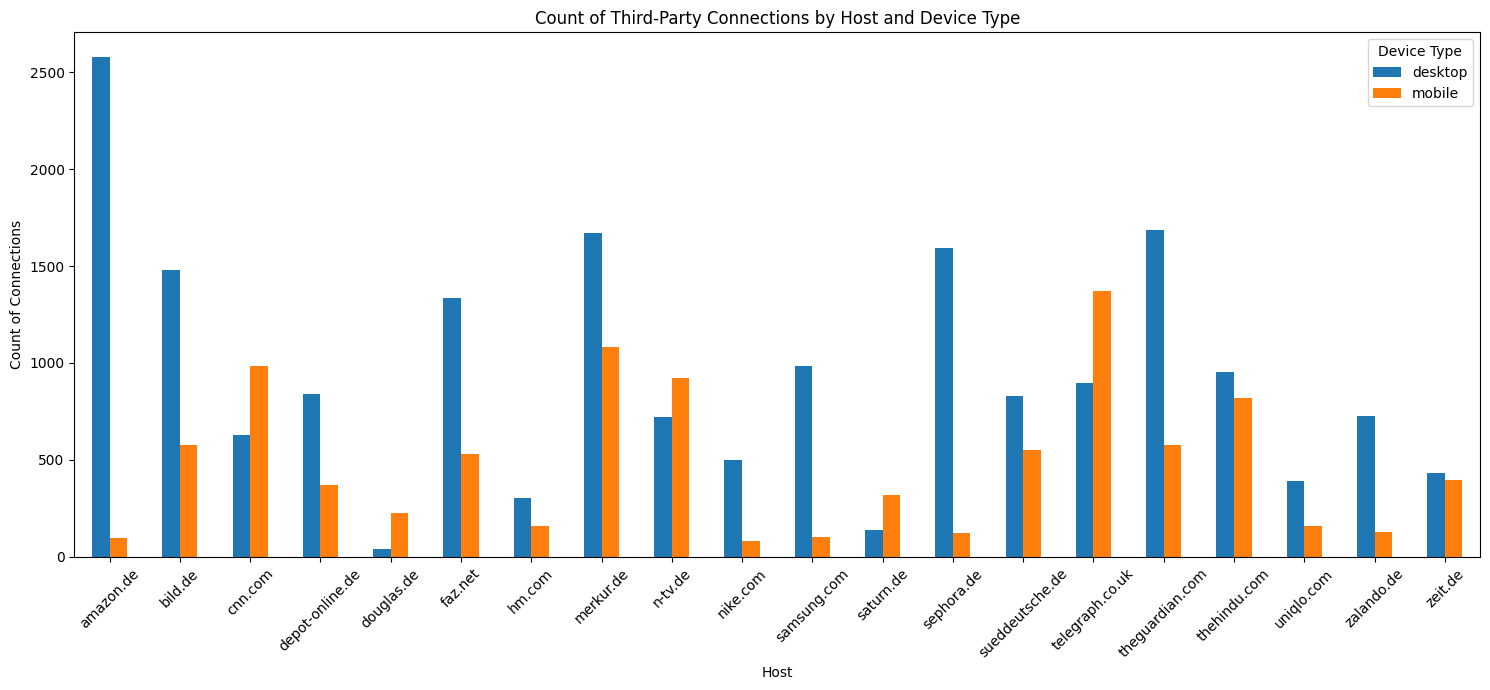

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data3, columns=['Host', 'Device Type', 'Count'])

pivot_df = df.pivot(index='Host', columns='Device Type', values='Count').fillna(0)

pivot_df.plot(kind='bar', figsize=(15, 7))

plt.title('Count of Third-Party Connections by Host and Device Type')
plt.xlabel('Host')
plt.ylabel('Count of Connections')
plt.xticks(rotation=45)
plt.legend(title='Device Type')
plt.tight_layout()

plt.show()

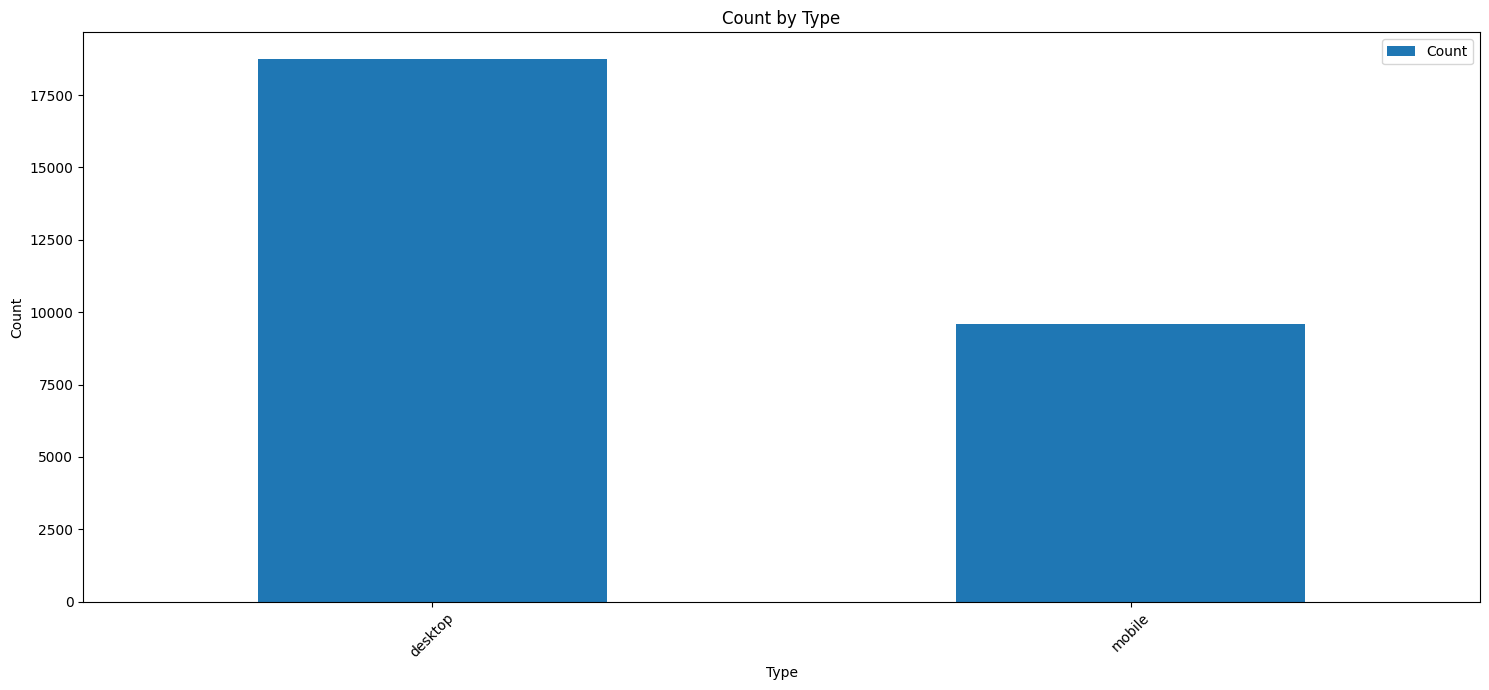

In [31]:
df = pd.DataFrame(data2, columns=['Type', 'Count'])

# Creating the bar chart
df.plot(kind='bar', x='Type', y='Count', figsize=(15, 7))

# Adding title and labels
plt.title('Count by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

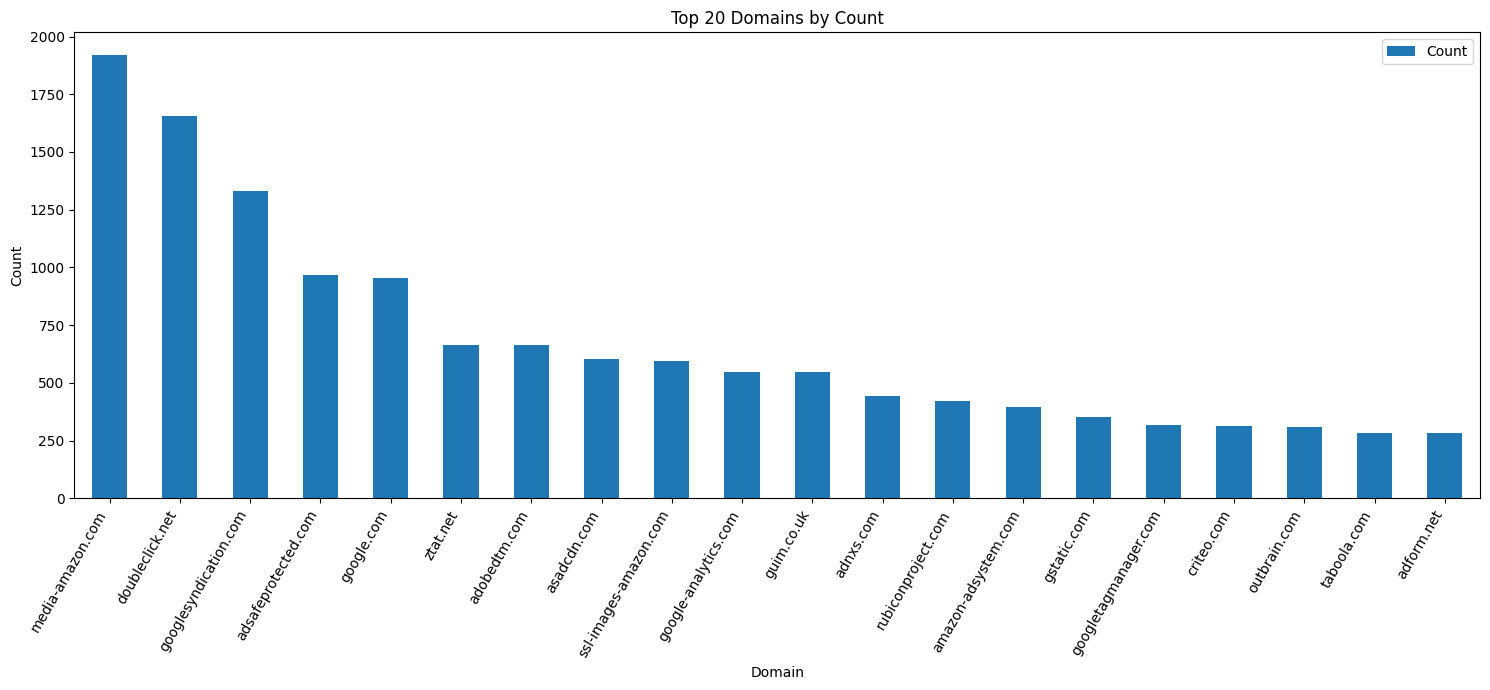

In [35]:
df = pd.DataFrame(data1, columns=['Domain', 'Count'])

df_top20 = df.head(20)

# Creating the bar chart for the top 20 domains
df_top20.plot(kind='bar', x='Domain', y='Count', figsize=(16, 7))

plt.title('Top 20 Domains by Count')
plt.xlabel('Domain')
plt.ylabel('Count')

# Adjust the rotation, font size, and alignment
plt.xticks(rotation=60, fontsize='medium', ha='right')  # ha is horizontal alignment

plt.tight_layout()
plt.show()
